<a href="https://colab.research.google.com/github/AdamClarkStandke/GenerativeDeepLearning/blob/main/KerasStableDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-cv==0.6.0 -q
!pip install -U tensorflow -q
!pip install keras-core -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.3/756.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 9.4 MB/s eta 0:00:00


In [17]:
from textwrap import wrap
import os

import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.models.stable_diffusion.noise_scheduler import NoiseScheduler
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
from tensorflow import keras
from keras_core import ops
from PIL import Image

In [3]:
data_path = tf.keras.utils.get_file(
    origin="https://huggingface.co/datasets/sayakpaul/pokemon-blip-original-version/resolve/main/pokemon_dataset.tar.gz",
    untar=True,
)

data_frame = pd.read_csv(os.path.join(data_path, "data.csv"))

data_frame["image_path"] = data_frame["image_path"].apply(
    lambda x: os.path.join(data_path, x)
)
data_frame.head()

347504640/347504640 [==============================] - 11s 0us/step


,image_path,caption
0,/root/.keras/datasets/pokemon_dataset/image_0.png,a drawing of a green pokemon with red eyes
1,/root/.keras/datasets/pokemon_dataset/image_1.png,a green and yellow toy with a red nose
2,/root/.keras/datasets/pokemon_dataset/image_2.png,a red and white ball with an angry look on its...
3,/root/.keras/datasets/pokemon_dataset/image_3.png,a cartoon ball with a smile on it's face
4,/root/.keras/datasets/pokemon_dataset/image_4.png,a bunch of balls with faces drawn on them


In [4]:
len(data_frame[:])

833

In [5]:
# The padding token and maximum prompt length are specific to the text encoder.
# If you're using a different text encoder be sure to change them accordingly.
PADDING_TOKEN = 49407
MAX_PROMPT_LENGTH = 77

# Load the tokenizer.
tokenizer = SimpleTokenizer()

#  Method to tokenize and pad the tokens.
def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [PADDING_TOKEN] * (MAX_PROMPT_LENGTH - len(tokens))
    return np.array(tokens)


# Collate the tokenized captions into an array.
tokenized_texts = np.empty((len(data_frame), MAX_PROMPT_LENGTH))

all_captions = list(data_frame["caption"].values)
for i, caption in enumerate(all_captions):
    tokenized_texts[i] = process_text(caption)

1356917/1356917 [==============================] - 0s 0us/step


In [6]:
# Enable mixed precision
# (only do this if you have a recent NVIDIA GPU)
keras.mixed_precision.set_global_policy("mixed_float16")

# Instantiate the Stable Diffusion model
model = keras_cv.models.StableDiffusion(jit_compile=True)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [12]:
prompt_1 = "A watercolor painting of a Golden Retriever at the beach"
prompt_2 = "A still life DSLR photo of a bowl of fruit"
interpolation_steps = 5

encoding_1 = ops.squeeze(model.encode_text(prompt_1))
encoding_2 = ops.squeeze(model.encode_text(prompt_2))

interpolated_encodings = ops.linspace(encoding_1, encoding_2, interpolation_steps)

# Show the size of the latent manifold
print(f"Encoding shape: {encoding_1.shape}")

492466864/492466864 [==============================] - 4s 0us/step
Encoding shape: (77, 768)


In [14]:
seed = 12345
noise = tf.random.normal((512 // 8, 512 // 8, 4), seed=seed)

images = model.generate_image(
    interpolated_encodings,
    batch_size=interpolation_steps,
    diffusion_noise=noise,
)

198180272/198180272 [==============================] - 1s 0us/step


In [18]:
def export_as_gif(filename, images, frames_per_second=10, rubber_band=False):
    if rubber_band:
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )


export_as_gif(
    "doggo-and-fruit-5.gif",
    [Image.fromarray(img) for img in images],
    frames_per_second=2,
    rubber_band=True,
)

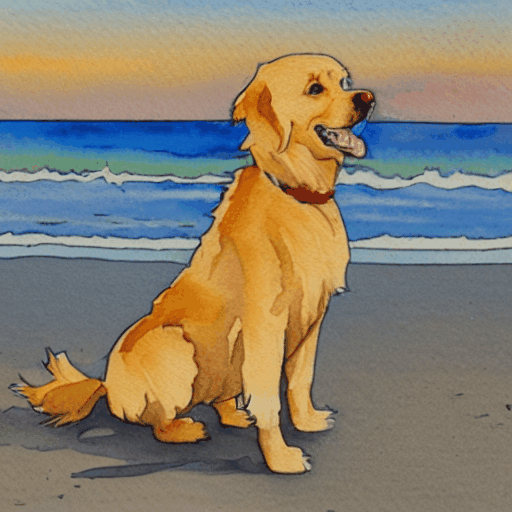

In [19]:
from IPython.display import Image as IImage
IImage("doggo-and-fruit-5.gif")